# Autoencoder for Simulated Sensor Data, Anomaly Detection

Epoch 1, Loss: 0.064807
Epoch 2, Loss: 0.024743
Epoch 3, Loss: 0.011310
Epoch 4, Loss: 0.009147
Epoch 5, Loss: 0.008187
Epoch 6, Loss: 0.007429
Epoch 7, Loss: 0.006607
Epoch 8, Loss: 0.005881
Epoch 9, Loss: 0.005186
Epoch 10, Loss: 0.004672
Epoch 11, Loss: 0.003917
Epoch 12, Loss: 0.003001
Epoch 13, Loss: 0.002039
Epoch 14, Loss: 0.001089
Epoch 15, Loss: 0.000343
Epoch 16, Loss: 0.000098
Epoch 17, Loss: 0.000057
Epoch 18, Loss: 0.000043
Epoch 19, Loss: 0.000039
Epoch 20, Loss: 0.000030
Epoch 21, Loss: 0.000026
Epoch 22, Loss: 0.000024
Epoch 23, Loss: 0.000023
Epoch 24, Loss: 0.000018
Epoch 25, Loss: 0.000016
Epoch 26, Loss: 0.000015
Epoch 27, Loss: 0.000014
Epoch 28, Loss: 0.000013
Epoch 29, Loss: 0.000012
Epoch 30, Loss: 0.000011
Epoch 31, Loss: 0.000011
Epoch 32, Loss: 0.000013
Epoch 33, Loss: 0.000011
Epoch 34, Loss: 0.000009
Epoch 35, Loss: 0.000010
Epoch 36, Loss: 0.000010
Epoch 37, Loss: 0.000008
Epoch 38, Loss: 0.000007
Epoch 39, Loss: 0.000007
Epoch 40, Loss: 0.000007
Epoch 41,

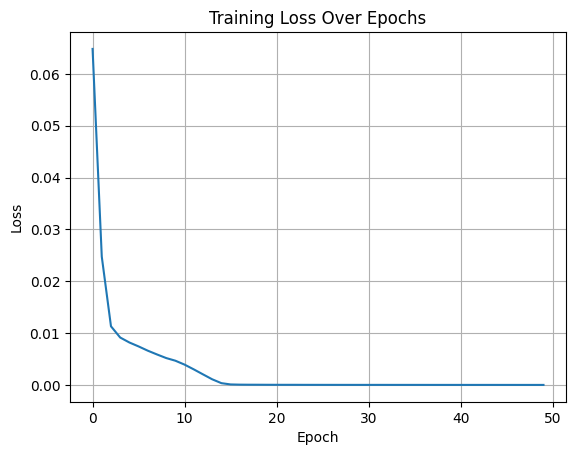

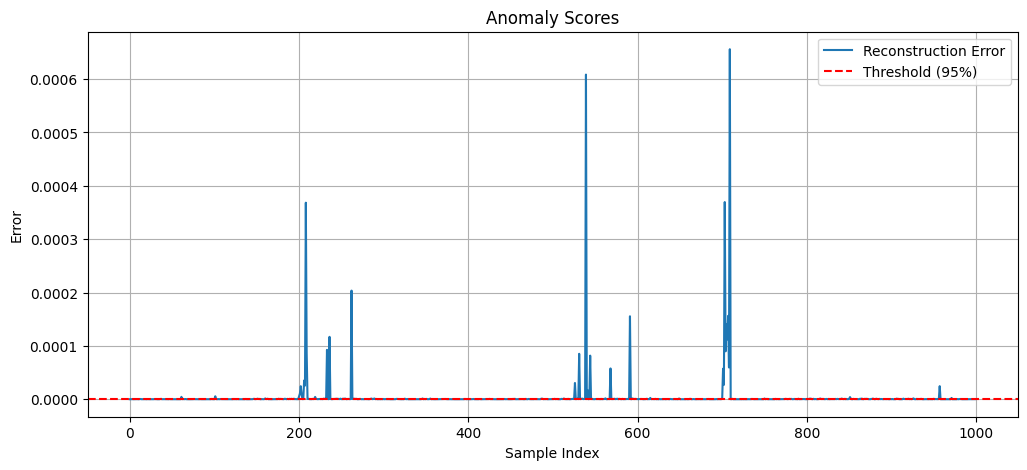

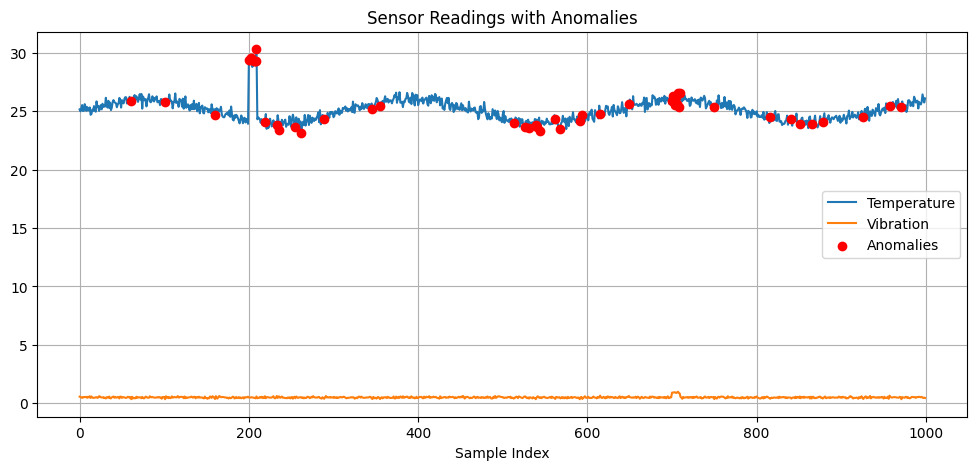

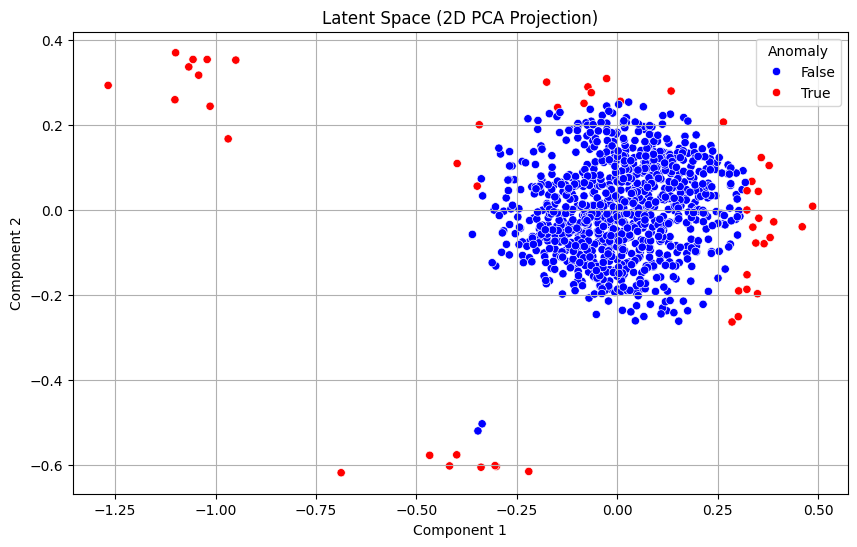

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import seaborn as sns

# Sensor data generation
np.random.seed(42)
n_samples = 1000

# Normal data with sinusoidal temp, stable vibration with noise
temperature = 25 + np.sin(np.linspace(0, 20, n_samples)) + np.random.normal(0, 0.3, n_samples)
vibration = 0.5 + np.random.normal(0, 0.05, n_samples)

# Inject anomalies
temperature[200:210] += 5  # sudden spike
vibration[700:710] += 0.4  # sudden shake

# Combine
data = np.vstack([temperature, vibration]).T
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

class SensorDataset(Dataset):
    def __init__(self, data):
        self.X = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

dataset = SensorDataset(data_scaled)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)

model = Autoencoder(input_dim=2)

# Training
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 50
losses = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        recon = model(batch)
        loss = criterion(recon, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.6f}")

plt.plot(losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Detect Anomalies
model.eval()
with torch.no_grad():
    inputs = torch.tensor(data_scaled, dtype=torch.float32)
    outputs = model(inputs)
    recon_error = torch.mean((inputs - outputs)**2, dim=1).numpy()

threshold = np.percentile(recon_error, 95)
anomalies = recon_error > threshold

# Plot anomaly scores
plt.figure(figsize=(12,5))
plt.plot(recon_error, label="Reconstruction Error")
plt.axhline(threshold, color='red', linestyle='--', label="Threshold (95%)")
plt.title("Anomaly Scores")
plt.xlabel("Sample Index")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()

# Highlight anomalies
plt.figure(figsize=(12,5))
plt.plot(data[:, 0], label="Temperature")
plt.plot(data[:, 1], label="Vibration")
plt.scatter(np.where(anomalies)[0], data[anomalies, 0], color='red', label="Anomalies", zorder=5)
plt.title("Sensor Readings with Anomalies")
plt.xlabel("Sample Index")
plt.legend()
plt.grid(True)
plt.show()

#LATENT SPACE VISUALIZATION 

# Get latent vectors from encoder
model.eval()
with torch.no_grad():
    inputs = torch.tensor(data_scaled, dtype=torch.float32)
    latents = model.encoder(inputs).numpy()

# Reduce to 2D with PCA for visualization
pca = PCA(n_components=2)
latents_2d = pca.fit_transform(latents)

# Plot with anomalies highlighted
plt.figure(figsize=(10,6))
sns.scatterplot(x=latents_2d[:,0], y=latents_2d[:,1], hue=anomalies, palette=["blue", "red"])
plt.title("Latent Space (2D PCA Projection)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Anomaly")
plt.grid(True)
plt.show()

